In [1]:
import numpy as np
import scipy.io as sio
import plot_utils as u
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.signal as signal

In [2]:
results_directory = Path('Zero_MPI_comparison/4s-new/')

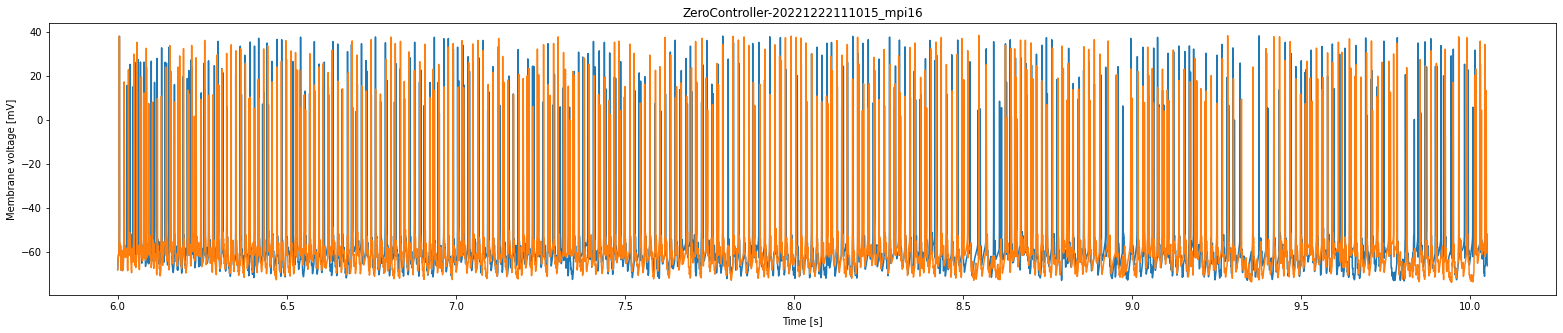

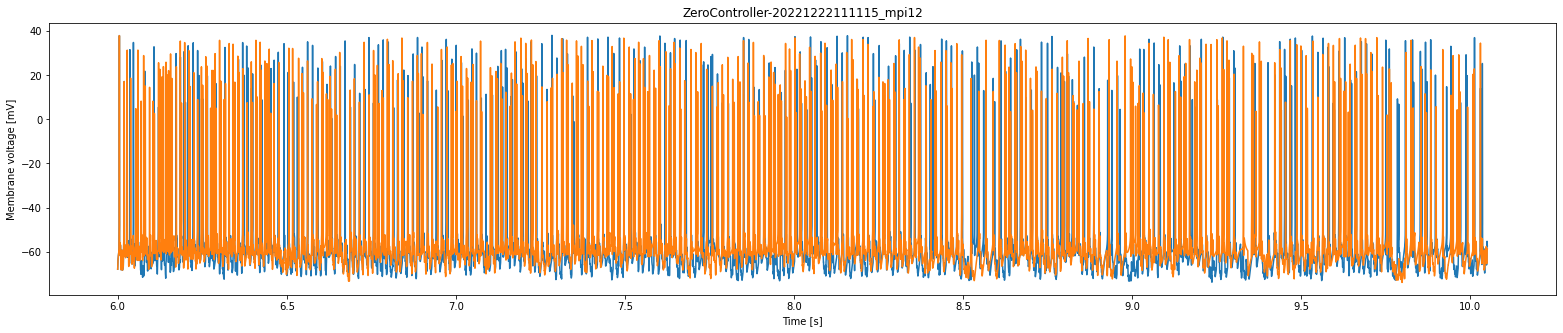

In [3]:
spikes_files = []
for i, single_result_directory in enumerate(results_directory.iterdir()):
    if not single_result_directory.is_dir():
        continue
    threads = int(single_result_directory.name.split("_mpi")[-1])
    for mat_file in sorted((single_result_directory / "STN_POP").iterdir(), key=lambda dir: int(dir.name.split("_")[0])):

        stn_soma_data = sio.loadmat(mat_file)
        if mat_file.name.split("_")[0] == "0":
            all_cell_voltage = stn_soma_data["block"]["segments"][0, 0][0, 0]["analogsignals"][0, 0][0, 0]["signal"][0, 0]
        else:
            stack = (all_cell_voltage, stn_soma_data["block"]["segments"][0, 0][0, 0]["analogsignals"][0, 0][0, 0]["signal"][0, 0])
            all_cell_voltage = np.vstack(stack)
        spikes_population = []
    for i in range(all_cell_voltage.shape[1]):
        spikes_cell = signal.find_peaks(all_cell_voltage[:, i], height=0)[0]
        spikes_population.append(spikes_cell)
    spikes_files.append({
        'threads': threads,
        'spikes': spikes_population
    })
    tt = np.linspace(6, all_cell_voltage.shape[0] / 2000, all_cell_voltage.shape[0])
    plt.figure(figsize=(27, 5))
    plt.title(single_result_directory.name)
    plt.xlabel("Time [s]")
    plt.ylabel("Membrane voltage [mV]")
    plt.plot(tt, all_cell_voltage[:, 0])
    plt.plot(tt, all_cell_voltage[:, 2])

In [4]:
thread_count_palette = {
    8: [[17 / 255, 57 / 255, 57 / 255], [], [], []],
    10: [[170 / 255, 220 / 255, 57 / 255], [], [], []],
    12: [[170 / 255, 57 / 255, 57 / 255], [], [], []],
    14: [[170 / 255, 108 / 255, 57 / 255], [], [], []],
    16: [[34 / 255, 102 / 255, 102 / 255], [], [], []],
    18: [[45 / 255, 136 / 255, 45 / 255], [], [], []],
}

12 threads, 347.36 spikes / neuron, 34736 spikes in total, mean ISI 28.94 ms (f = 34.56 Hz)
16 threads, 348.95 spikes / neuron, 34895 spikes in total, mean ISI 28.82 ms (f = 34.70 Hz)


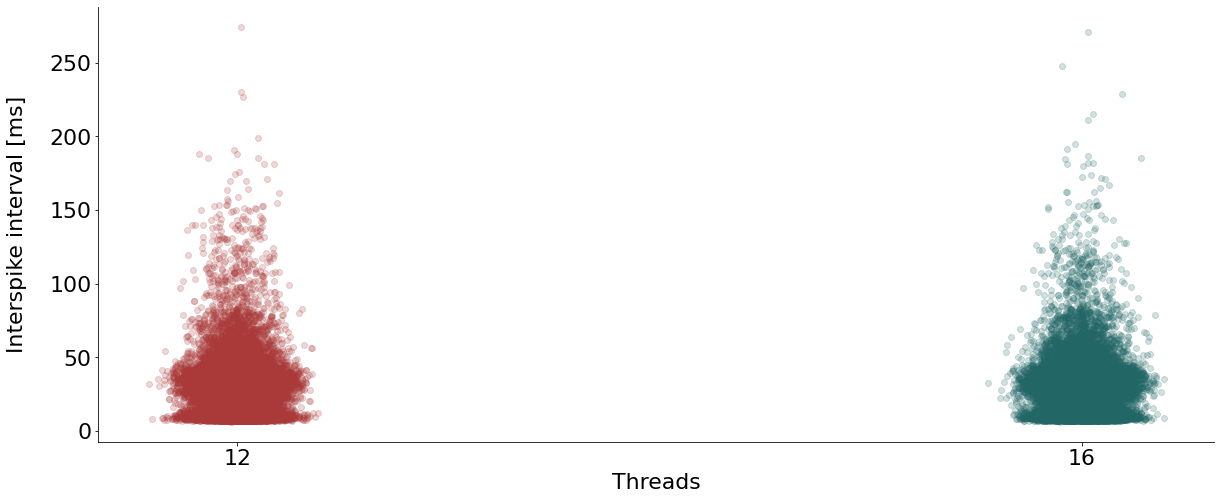

In [5]:
fig = plt.figure(figsize=(20, 8))
ax = plt.gca()
x_axis_labels = set()
for f in sorted(spikes_files, key=lambda f: f["threads"]):
    x_axis_labels.add(f["threads"])
    isi = []
    for spikes in f["spikes"]:
        isi.extend(np.diff(spikes) / 2)
    mean_spikes = np.mean(np.array([e.shape[0] for e in f["spikes"]]))
    total_spikes = np.sum([np.count_nonzero(e) for e in f["spikes"]])
    
    print(f"{f['threads']} threads, {mean_spikes} spikes / neuron, {total_spikes} spikes in total, mean ISI {np.mean(np.array(isi)):.2f} ms (f = {1000 / np.mean(np.array(isi)):.2f} Hz)")
    
    ax.scatter(f["threads"] * np.ones(len(isi)) + np.random.normal(0, 0.1, size=len(isi)), isi, alpha=0.2, color=thread_count_palette[f["threads"]][0])
ax.set_xlabel("Threads", fontsize=22)
ax.set_ylabel("Interspike interval [ms]", fontsize=22, labelpad=22)
ax.set_xticks(sorted(list(x_axis_labels)))
ax.tick_params(axis="both", which="major", labelsize=22)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
    